In [1]:
# imports
import os
import sys
import time
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# from tf_cnnvis import *

np.random.seed(10)

%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# helper method to define model
def deepnn(x):
    x_image = tf.reshape(x, [-1, 32, 32, 3])
    x_image = tf.image.resize_image_with_crop_or_pad(x_image, target_height=32, target_width=32)

    W_conv1 = weight_variable([5, 5, 3, 6])
    b_conv1 = bias_variable([6])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([5, 5, 6, 16])
    b_conv2 = bias_variable([16])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    h_pool2 = max_pool_2x2(h_conv2)

    W_conv3 = weight_variable([5, 5, 16, 10])
    b_conv3 = bias_variable([10])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    
    h_pool3 = max_pool_2x2(h_conv3)
    
    gap_1 = tf.nn.avg_pool(h_pool3, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    
    dense = tf.reshape(gap_1, [-1, 10])
    
    return x_image, dense, h_conv1, h_pool1, h_conv2, h_pool2, h_conv3, h_pool3, gap_1


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [3]:
def read_data(file_q):
    
    class CIFAR10Record(object):
        pass
    
    result = CIFAR10Record()
    
    label_bytes = 1
    result.height = 32
    result.width = 32
    result.depth = 3
    image_bytes = result.height * result.width * result.depth
    
    record_bytes = image_bytes + label_bytes
    
#     dict = unpickle()
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    result.key, value = reader.read(file_q)
    
    record_bytes = tf.decode_raw(value, tf.uint8)
    
    result.label = tf.cast(tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32)
    
    depth_major = tf.reshape(tf.strided_slice(record_bytes, [label_bytes], [label_bytes + image_bytes]), 
                            [result.depth, result.height, result.width])
    
    result.uint8image = tf.transpose(depth_major, [1, 2, 0])
    
    reshaped_image = tf.cast(result.uint8image, tf.float32)
    
    height = 32
    width = 32
    
    float_image = tf.image.per_image_standardization(reshaped_image)
    
    float_image.set_shape([height, width, 3])
    result.label.set_shape([1])
    one_hot_result = tf.one_hot(result.label, 10)
    one_hot_result.set_shape([1, 10])
    
    print('float_image = ' + str(float_image.get_shape().as_list()))
    print('result_label = ' + str(result.label.get_shape().as_list()))
    
    return float_image, one_hot_result

In [4]:
def cifar_run(image, label):
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        print(len(threads))
        for i in range(1):
            image_batch, label_batch = sess.run([image, label])
            label_batch = label_batch.reshape(-1, 10)
#             print(image_batch.shape, label_batch.shape)
            print(label_batch)
            
        coord.request_stop()
        coord.join(threads)

In [5]:
data_path = '/home/lenovo/Documents/IITB/code/Visualising Convolutional Networks/cifar/cifar-10-batches-bin/'

def cifar_shuffle_batch():
    
    batch_size = 128
    num_threads = 16
    
    filename_list = [data_path + 'data_batch_{}.bin'.format(i+1) for i in range(5)]
    
#     file_q = cifar_filename_queue(filename_list)
    file_q = tf.train.string_input_producer(filename_list)
    
    image, label = read_data(file_q)
    
    
    min_after_dequeue = 10000
    
    capacity = min_after_dequeue + (num_threads + 1) * batch_size
    
#     image_batch, label_batch = cifar_shuffle_queue_batch(image, label, batch_size, capacity, min_after_dequeue, num_threads)
    image_batch, label_batch = tf.train.shuffle_batch([image, label], batch_size, capacity, min_after_dequeue, num_threads=num_threads)
    
    cifar_run(image_batch, label_batch)

In [6]:
#load graph and data and run training

tf.reset_default_graph()

# defining TF model
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, [None, 10])
x_image, y_conv, h_conv1, h_pool1, h_conv2, h_pool2, h_conv3, h_pool3, gap_1 = deepnn(x)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_conv, labels = y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training CNN
batch_size = 128
num_threads = 16

filename_list = [data_path + 'data_batch_{}.bin'.format(i+1) for i in range(5)]

#     file_q = cifar_filename_queue(filename_list)
file_q = tf.train.string_input_producer(filename_list)

image, label = read_data(file_q)


min_after_dequeue = 10000

capacity = min_after_dequeue + (num_threads + 1) * batch_size

#     image_batch, label_batch = cifar_shuffle_queue_batch(image, label, batch_size, capacity, min_after_dequeue, num_threads)
image_batch, label_batch = tf.train.shuffle_batch([image, label], batch_size, capacity, min_after_dequeue, num_threads=num_threads)   

saver = tf.train.Saver(max_to_keep=100, keep_checkpoint_every_n_hours=1)
sess= tf.Session()

sess.run(tf.global_variables_initializer())
with sess.as_default():
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for i in range(20000):
#         batch = mnist.train.next_batch(50)
        image_feed, label_feed = sess.run([image_batch, label_batch])
        label_feed = label_feed.reshape(-1, 10)
        if i%10 == 0:
            saver.save(sess, './cifar_model/model_chkpt', global_step=i)
            train_accuracy = accuracy.eval(feed_dict={x:image_feed, y_: label_feed})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: image_feed, y_: label_feed})
        
#     x_feed = mnist.test.images.reshape(-1, 784)[:100]
#     y_feed = mnist.test.labels.reshape(-1, 10)[:100]
#     print("test accuracy %g"%accuracy.eval(feed_dict={x: x_feed, y_: y_feed, 
#                                                       }))

#     test_x = mnist.test.images.reshape(-1, 784)[0]
#     test_y = mnist.test.images.reshape(-1, 10)[0]
#     feed_dict = {x: test_x, y:test_y}

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

float_image = [32, 32, 3]
result_label = [1]
step 0, training accuracy 0.078125
step 10, training accuracy 0.117188
step 20, training accuracy 0.101562
step 30, training accuracy 0.171875
step 40, training accuracy 0.109375
step 50, training accuracy 0.148438
step 60, training accuracy 0.117188
step 70, training accuracy 0.171875
step 80, training accuracy 0.171875
step 90, training accuracy 0.15625
step 100, training accuracy 0.179688
step 110, training accuracy 0.226562
step 120, training accuracy 0.210938
step 130, training accuracy 0.164062
step 140, training accuracy 0.148438
step 150, training accuracy 0.195312
step 160, training accuracy 0.203125
step 170, training accuracy 0.203125
step 180, training accuracy 0.265625
step 190, training accuracy 0.25
step 200, training accuracy 0.257812
step 

step 2100, training accuracy 0.414062
step 2110, training accuracy 0.429688
step 2120, training accuracy 0.390625
step 2130, training accuracy 0.476562
step 2140, training accuracy 0.429688
step 2150, training accuracy 0.382812
step 2160, training accuracy 0.40625
step 2170, training accuracy 0.359375
step 2180, training accuracy 0.429688
step 2190, training accuracy 0.375
step 2200, training accuracy 0.414062
step 2210, training accuracy 0.375
step 2220, training accuracy 0.421875
step 2230, training accuracy 0.351562
step 2240, training accuracy 0.351562
step 2250, training accuracy 0.382812
step 2260, training accuracy 0.414062
step 2270, training accuracy 0.390625
step 2280, training accuracy 0.359375
step 2290, training accuracy 0.367188
step 2300, training accuracy 0.382812
step 2310, training accuracy 0.367188
step 2320, training accuracy 0.414062
step 2330, training accuracy 0.34375
step 2340, training accuracy 0.375
step 2350, training accuracy 0.375
step 2360, training accura

step 4290, training accuracy 0.453125
step 4300, training accuracy 0.453125
step 4310, training accuracy 0.390625
step 4320, training accuracy 0.359375
step 4330, training accuracy 0.4375
step 4340, training accuracy 0.390625
step 4350, training accuracy 0.375
step 4360, training accuracy 0.34375
step 4370, training accuracy 0.359375
step 4380, training accuracy 0.382812
step 4390, training accuracy 0.328125
step 4400, training accuracy 0.375
step 4410, training accuracy 0.40625
step 4420, training accuracy 0.375
step 4430, training accuracy 0.382812
step 4440, training accuracy 0.414062
step 4450, training accuracy 0.476562
step 4460, training accuracy 0.453125
step 4470, training accuracy 0.421875
step 4480, training accuracy 0.4375
step 4490, training accuracy 0.554688
step 4500, training accuracy 0.5
step 4510, training accuracy 0.523438
step 4520, training accuracy 0.398438
step 4530, training accuracy 0.414062
step 4540, training accuracy 0.453125
step 4550, training accuracy 0.4

step 6480, training accuracy 0.367188
step 6490, training accuracy 0.460938
step 6500, training accuracy 0.539062
step 6510, training accuracy 0.445312
step 6520, training accuracy 0.484375
step 6530, training accuracy 0.4375
step 6540, training accuracy 0.398438
step 6550, training accuracy 0.429688
step 6560, training accuracy 0.382812
step 6570, training accuracy 0.5
step 6580, training accuracy 0.40625
step 6590, training accuracy 0.484375
step 6600, training accuracy 0.421875
step 6610, training accuracy 0.367188
step 6620, training accuracy 0.515625
step 6630, training accuracy 0.398438
step 6640, training accuracy 0.5
step 6650, training accuracy 0.46875
step 6660, training accuracy 0.460938
step 6670, training accuracy 0.445312
step 6680, training accuracy 0.40625
step 6690, training accuracy 0.445312
step 6700, training accuracy 0.523438
step 6710, training accuracy 0.460938
step 6720, training accuracy 0.539062
step 6730, training accuracy 0.445312
step 6740, training accurac

step 8680, training accuracy 0.445312
step 8690, training accuracy 0.484375
step 8700, training accuracy 0.429688
step 8710, training accuracy 0.546875
step 8720, training accuracy 0.4375
step 8730, training accuracy 0.398438
step 8740, training accuracy 0.460938
step 8750, training accuracy 0.46875
step 8760, training accuracy 0.523438
step 8770, training accuracy 0.507812
step 8780, training accuracy 0.429688
step 8790, training accuracy 0.460938
step 8800, training accuracy 0.53125
step 8810, training accuracy 0.476562
step 8820, training accuracy 0.445312
step 8830, training accuracy 0.523438
step 8840, training accuracy 0.453125
step 8850, training accuracy 0.5
step 8860, training accuracy 0.46875
step 8870, training accuracy 0.476562
step 8880, training accuracy 0.476562
step 8890, training accuracy 0.40625
step 8900, training accuracy 0.476562
step 8910, training accuracy 0.492188
step 8920, training accuracy 0.445312
step 8930, training accuracy 0.390625
step 8940, training acc

step 10840, training accuracy 0.554688
step 10850, training accuracy 0.539062
step 10860, training accuracy 0.539062
step 10870, training accuracy 0.5625
step 10880, training accuracy 0.421875
step 10890, training accuracy 0.445312
step 10900, training accuracy 0.5
step 10910, training accuracy 0.492188
step 10920, training accuracy 0.523438
step 10930, training accuracy 0.460938
step 10940, training accuracy 0.414062
step 10950, training accuracy 0.515625
step 10960, training accuracy 0.429688
step 10970, training accuracy 0.398438
step 10980, training accuracy 0.5
step 10990, training accuracy 0.484375
step 11000, training accuracy 0.460938
step 11010, training accuracy 0.546875
step 11020, training accuracy 0.53125
step 11030, training accuracy 0.523438
step 11040, training accuracy 0.59375
step 11050, training accuracy 0.492188
step 11060, training accuracy 0.484375
step 11070, training accuracy 0.507812
step 11080, training accuracy 0.523438
step 11090, training accuracy 0.46875
s

step 12980, training accuracy 0.59375
step 12990, training accuracy 0.523438
step 13000, training accuracy 0.53125
step 13010, training accuracy 0.484375
step 13020, training accuracy 0.484375
step 13030, training accuracy 0.53125
step 13040, training accuracy 0.515625
step 13050, training accuracy 0.398438
step 13060, training accuracy 0.539062
step 13070, training accuracy 0.484375
step 13080, training accuracy 0.53125
step 13090, training accuracy 0.53125
step 13100, training accuracy 0.40625
step 13110, training accuracy 0.515625
step 13120, training accuracy 0.492188
step 13130, training accuracy 0.492188
step 13140, training accuracy 0.507812
step 13150, training accuracy 0.476562
step 13160, training accuracy 0.515625
step 13170, training accuracy 0.453125
step 13180, training accuracy 0.46875
step 13190, training accuracy 0.460938
step 13200, training accuracy 0.398438
step 13210, training accuracy 0.53125
step 13220, training accuracy 0.546875
step 13230, training accuracy 0.5

step 15120, training accuracy 0.484375
step 15130, training accuracy 0.5625
step 15140, training accuracy 0.539062
step 15150, training accuracy 0.40625
step 15160, training accuracy 0.453125
step 15170, training accuracy 0.476562
step 15180, training accuracy 0.453125
step 15190, training accuracy 0.53125
step 15200, training accuracy 0.507812
step 15210, training accuracy 0.484375
step 15220, training accuracy 0.585938
step 15230, training accuracy 0.609375
step 15240, training accuracy 0.539062
step 15250, training accuracy 0.539062
step 15260, training accuracy 0.515625
step 15270, training accuracy 0.546875
step 15280, training accuracy 0.460938
step 15290, training accuracy 0.507812
step 15300, training accuracy 0.539062
step 15310, training accuracy 0.539062
step 15320, training accuracy 0.476562
step 15330, training accuracy 0.492188
step 15340, training accuracy 0.515625
step 15350, training accuracy 0.476562
step 15360, training accuracy 0.453125
step 15370, training accuracy

step 17260, training accuracy 0.53125
step 17270, training accuracy 0.5
step 17280, training accuracy 0.460938
step 17290, training accuracy 0.523438
step 17300, training accuracy 0.492188
step 17310, training accuracy 0.484375
step 17320, training accuracy 0.523438
step 17330, training accuracy 0.53125
step 17340, training accuracy 0.492188
step 17350, training accuracy 0.507812
step 17360, training accuracy 0.523438
step 17370, training accuracy 0.5
step 17380, training accuracy 0.453125
step 17390, training accuracy 0.585938
step 17400, training accuracy 0.492188
step 17410, training accuracy 0.460938
step 17420, training accuracy 0.53125
step 17430, training accuracy 0.570312
step 17440, training accuracy 0.476562
step 17450, training accuracy 0.523438
step 17460, training accuracy 0.523438
step 17470, training accuracy 0.5625
step 17480, training accuracy 0.414062
step 17490, training accuracy 0.546875
step 17500, training accuracy 0.539062
step 17510, training accuracy 0.515625
s

step 19390, training accuracy 0.59375
step 19400, training accuracy 0.492188
step 19410, training accuracy 0.484375
step 19420, training accuracy 0.5625
step 19430, training accuracy 0.554688
step 19440, training accuracy 0.5625
step 19450, training accuracy 0.578125
step 19460, training accuracy 0.5
step 19470, training accuracy 0.507812
step 19480, training accuracy 0.46875
step 19490, training accuracy 0.5625
step 19500, training accuracy 0.523438
step 19510, training accuracy 0.484375
step 19520, training accuracy 0.484375
step 19530, training accuracy 0.5
step 19540, training accuracy 0.53125
step 19550, training accuracy 0.625
step 19560, training accuracy 0.632812
step 19570, training accuracy 0.5625
step 19580, training accuracy 0.445312
step 19590, training accuracy 0.5625
step 19600, training accuracy 0.539062
step 19610, training accuracy 0.484375
step 19620, training accuracy 0.523438
step 19630, training accuracy 0.59375
step 19640, training accuracy 0.492188
step 19650, t

In [7]:
with sess.as_default():
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for i in range(20000):
#         batch = mnist.train.next_batch(50)
        image_feed, label_feed = sess.run([image_batch, label_batch])
        label_feed = label_feed.reshape(-1, 10)
        if i%10 == 0:
            saver.save(sess, './cifar_model/model_chkpt', global_step=i)
            train_accuracy = accuracy.eval(feed_dict={x:image_feed, y_: label_feed})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: image_feed, y_: label_feed})

step 0, training accuracy 0.578125
step 10, training accuracy 0.53125
step 20, training accuracy 0.554688
step 30, training accuracy 0.554688
step 40, training accuracy 0.492188
step 50, training accuracy 0.59375
step 60, training accuracy 0.453125
step 70, training accuracy 0.546875
step 80, training accuracy 0.484375
step 90, training accuracy 0.484375
step 100, training accuracy 0.5
step 110, training accuracy 0.554688
step 120, training accuracy 0.445312
step 130, training accuracy 0.625
step 140, training accuracy 0.53125
step 150, training accuracy 0.507812
step 160, training accuracy 0.507812
step 170, training accuracy 0.429688
step 180, training accuracy 0.421875
step 190, training accuracy 0.539062
step 200, training accuracy 0.539062
step 210, training accuracy 0.578125
step 220, training accuracy 0.585938
step 230, training accuracy 0.554688
step 240, training accuracy 0.5625
step 250, training accuracy 0.445312
step 260, training accuracy 0.5625
step 270, training accuracy

step 2220, training accuracy 0.46875
step 2230, training accuracy 0.492188
step 2240, training accuracy 0.445312
step 2250, training accuracy 0.4375
step 2260, training accuracy 0.539062
step 2270, training accuracy 0.515625
step 2280, training accuracy 0.484375
step 2290, training accuracy 0.539062
step 2300, training accuracy 0.585938
step 2310, training accuracy 0.484375
step 2320, training accuracy 0.5
step 2330, training accuracy 0.554688
step 2340, training accuracy 0.546875
step 2350, training accuracy 0.5625
step 2360, training accuracy 0.539062
step 2370, training accuracy 0.554688
step 2380, training accuracy 0.617188
step 2390, training accuracy 0.523438
step 2400, training accuracy 0.539062
step 2410, training accuracy 0.539062
step 2420, training accuracy 0.445312
step 2430, training accuracy 0.609375
step 2440, training accuracy 0.53125
step 2450, training accuracy 0.5625
step 2460, training accuracy 0.453125
step 2470, training accuracy 0.484375
step 2480, training accur

step 4410, training accuracy 0.5625
step 4420, training accuracy 0.515625
step 4430, training accuracy 0.507812
step 4440, training accuracy 0.585938
step 4450, training accuracy 0.515625
step 4460, training accuracy 0.570312
step 4470, training accuracy 0.523438
step 4480, training accuracy 0.601562
step 4490, training accuracy 0.554688
step 4500, training accuracy 0.570312
step 4510, training accuracy 0.59375
step 4520, training accuracy 0.554688
step 4530, training accuracy 0.460938
step 4540, training accuracy 0.492188
step 4550, training accuracy 0.492188
step 4560, training accuracy 0.546875
step 4570, training accuracy 0.539062
step 4580, training accuracy 0.507812
step 4590, training accuracy 0.492188
step 4600, training accuracy 0.484375
step 4610, training accuracy 0.515625
step 4620, training accuracy 0.515625
step 4630, training accuracy 0.632812
step 4640, training accuracy 0.5625
step 4650, training accuracy 0.59375
step 4660, training accuracy 0.609375
step 4670, trainin

step 6600, training accuracy 0.578125
step 6610, training accuracy 0.539062
step 6620, training accuracy 0.609375
step 6630, training accuracy 0.578125
step 6640, training accuracy 0.484375
step 6650, training accuracy 0.59375
step 6660, training accuracy 0.632812
step 6670, training accuracy 0.492188
step 6680, training accuracy 0.507812
step 6690, training accuracy 0.539062
step 6700, training accuracy 0.5625
step 6710, training accuracy 0.515625
step 6720, training accuracy 0.570312
step 6730, training accuracy 0.539062
step 6740, training accuracy 0.546875
step 6750, training accuracy 0.59375
step 6760, training accuracy 0.53125
step 6770, training accuracy 0.507812
step 6780, training accuracy 0.570312
step 6790, training accuracy 0.570312
step 6800, training accuracy 0.546875
step 6810, training accuracy 0.515625
step 6820, training accuracy 0.515625
step 6830, training accuracy 0.625
step 6840, training accuracy 0.523438
step 6850, training accuracy 0.5625
step 6860, training ac

step 8790, training accuracy 0.53125
step 8800, training accuracy 0.578125
step 8810, training accuracy 0.554688
step 8820, training accuracy 0.539062
step 8830, training accuracy 0.492188
step 8840, training accuracy 0.546875
step 8850, training accuracy 0.554688
step 8860, training accuracy 0.5625
step 8870, training accuracy 0.617188
step 8880, training accuracy 0.53125
step 8890, training accuracy 0.507812
step 8900, training accuracy 0.492188
step 8910, training accuracy 0.554688
step 8920, training accuracy 0.546875
step 8930, training accuracy 0.53125
step 8940, training accuracy 0.5
step 8950, training accuracy 0.492188
step 8960, training accuracy 0.539062
step 8970, training accuracy 0.570312
step 8980, training accuracy 0.515625
step 8990, training accuracy 0.53125
step 9000, training accuracy 0.632812
step 9010, training accuracy 0.65625
step 9020, training accuracy 0.609375
step 9030, training accuracy 0.5625
step 9040, training accuracy 0.578125
step 9050, training accura

step 10960, training accuracy 0.5
step 10970, training accuracy 0.546875
step 10980, training accuracy 0.539062
step 10990, training accuracy 0.554688
step 11000, training accuracy 0.554688
step 11010, training accuracy 0.515625
step 11020, training accuracy 0.617188
step 11030, training accuracy 0.5625
step 11040, training accuracy 0.617188
step 11050, training accuracy 0.5
step 11060, training accuracy 0.484375
step 11070, training accuracy 0.554688
step 11080, training accuracy 0.539062
step 11090, training accuracy 0.53125
step 11100, training accuracy 0.625
step 11110, training accuracy 0.625
step 11120, training accuracy 0.484375
step 11130, training accuracy 0.609375
step 11140, training accuracy 0.554688
step 11150, training accuracy 0.554688
step 11160, training accuracy 0.570312
step 11170, training accuracy 0.648438
step 11180, training accuracy 0.554688
step 11190, training accuracy 0.53125
step 11200, training accuracy 0.578125
step 11210, training accuracy 0.476562
step 1

step 13100, training accuracy 0.484375
step 13110, training accuracy 0.570312
step 13120, training accuracy 0.546875
step 13130, training accuracy 0.570312
step 13140, training accuracy 0.5625
step 13150, training accuracy 0.65625
step 13160, training accuracy 0.523438
step 13170, training accuracy 0.445312
step 13180, training accuracy 0.539062
step 13190, training accuracy 0.5625
step 13200, training accuracy 0.515625
step 13210, training accuracy 0.585938
step 13220, training accuracy 0.570312
step 13230, training accuracy 0.585938
step 13240, training accuracy 0.554688
step 13250, training accuracy 0.59375
step 13260, training accuracy 0.625
step 13270, training accuracy 0.460938
step 13280, training accuracy 0.578125
step 13290, training accuracy 0.609375
step 13300, training accuracy 0.539062
step 13310, training accuracy 0.5625
step 13320, training accuracy 0.546875
step 13330, training accuracy 0.554688
step 13340, training accuracy 0.640625
step 13350, training accuracy 0.5156

step 15230, training accuracy 0.539062
step 15240, training accuracy 0.484375
step 15250, training accuracy 0.578125
step 15260, training accuracy 0.617188
step 15270, training accuracy 0.546875
step 15280, training accuracy 0.617188
step 15290, training accuracy 0.539062
step 15300, training accuracy 0.648438
step 15310, training accuracy 0.585938
step 15320, training accuracy 0.59375
step 15330, training accuracy 0.640625
step 15340, training accuracy 0.492188
step 15350, training accuracy 0.5625
step 15360, training accuracy 0.5625
step 15370, training accuracy 0.554688
step 15380, training accuracy 0.539062
step 15390, training accuracy 0.570312
step 15400, training accuracy 0.570312
step 15410, training accuracy 0.46875
step 15420, training accuracy 0.625
step 15430, training accuracy 0.554688
step 15440, training accuracy 0.601562
step 15450, training accuracy 0.539062
step 15460, training accuracy 0.617188
step 15470, training accuracy 0.570312
step 15480, training accuracy 0.59

step 17350, training accuracy 0.578125
step 17360, training accuracy 0.570312
step 17370, training accuracy 0.585938
step 17380, training accuracy 0.539062
step 17390, training accuracy 0.53125
step 17400, training accuracy 0.578125
step 17410, training accuracy 0.609375
step 17420, training accuracy 0.585938
step 17430, training accuracy 0.570312
step 17440, training accuracy 0.601562
step 17450, training accuracy 0.625
step 17460, training accuracy 0.554688
step 17470, training accuracy 0.53125
step 17480, training accuracy 0.578125
step 17490, training accuracy 0.546875
step 17500, training accuracy 0.5
step 17510, training accuracy 0.546875
step 17520, training accuracy 0.59375
step 17530, training accuracy 0.5
step 17540, training accuracy 0.523438
step 17550, training accuracy 0.5
step 17560, training accuracy 0.5625
step 17570, training accuracy 0.585938
step 17580, training accuracy 0.507812
step 17590, training accuracy 0.554688
step 17600, training accuracy 0.554688
step 1761

step 19490, training accuracy 0.523438
step 19500, training accuracy 0.5625
step 19510, training accuracy 0.671875
step 19520, training accuracy 0.539062
step 19530, training accuracy 0.554688
step 19540, training accuracy 0.578125
step 19550, training accuracy 0.554688
step 19560, training accuracy 0.609375
step 19570, training accuracy 0.539062
step 19580, training accuracy 0.585938
step 19590, training accuracy 0.53125
step 19600, training accuracy 0.5625
step 19610, training accuracy 0.585938
step 19620, training accuracy 0.585938
step 19630, training accuracy 0.539062
step 19640, training accuracy 0.578125
step 19650, training accuracy 0.507812
step 19660, training accuracy 0.453125
step 19670, training accuracy 0.609375
step 19680, training accuracy 0.546875
step 19690, training accuracy 0.632812
step 19700, training accuracy 0.5625
step 19710, training accuracy 0.632812
step 19720, training accuracy 0.554688
step 19730, training accuracy 0.523438
step 19740, training accuracy 0.

In [5]:
saver = tf.train.Saver()

saver.restore(sess, './model/deconv_gap_chkpt')


# deconv visualization
test_x = mnist.test.images.reshape(-1, 784)[0:1]
test_y = mnist.test.labels.reshape(-1, 10)[0:1]

feed_dict = {x: test_x, y_:test_y}

# layers = ["r", "p", "c"]
# total_time = 0

# start = time.time()
#     # api call
# is_success = deconv_visualization(sess_graph_path = sess, value_feed_dict = feed_dict, 
#                                   input_tensor=x_image, layers=layers, 
#                                   path_logdir=os.path.join("Log","MNISTExample"), 
#                                   path_outdir=os.path.join("Output","MNISTExample"))
# start = time.time() - start
# print("Total Time = %f" % (start))

INFO:tensorflow:Restoring parameters from ./model/deconv_gap_chkpt


In [10]:
# start = time.time()
#     # api call
# is_success = activation_visualization(sess_graph_path = sess, value_feed_dict = feed_dict, 
#                                   input_tensor=x_image, layers=layers, 
#                                   path_logdir=os.path.join("Log","MNISTExample"), 
#                                   path_outdir=os.path.join("Output","MNISTExample"))
# start = time.time() - start
# print("Total Time = %f" % (start))

INFO:tensorflow:Restoring parameters from model/tmp-model
Reconstruction Completed for Relu layer. Time taken = 0.673796 s
Reconstruction Completed for Relu_1 layer. Time taken = 0.049525 s
Reconstruction Completed for Relu_2 layer. Time taken = 0.081727 s
Reconstruction Completed for Relu_3 layer. Time taken = 0.036901 s
Reconstruction Completed for MaxPool layer. Time taken = 0.028609 s
Reconstruction Completed for MaxPool_1 layer. Time taken = 0.042631 s
Reconstruction Completed for Conv2D layer. Time taken = 0.047269 s
Reconstruction Completed for Conv2D_1 layer. Time taken = 0.032229 s
Total Time = 4.159668


In [6]:
import matplotlib.pyplot as plt

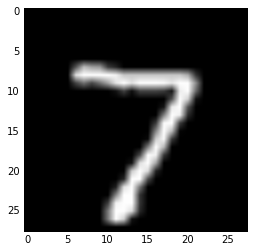

In [7]:
plt.imshow(test_x.reshape(28, 28), cmap='gray')

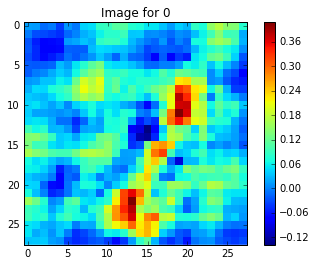

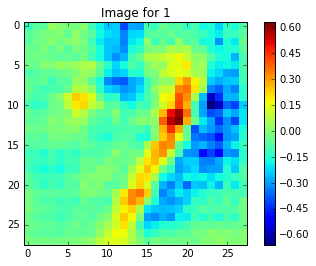

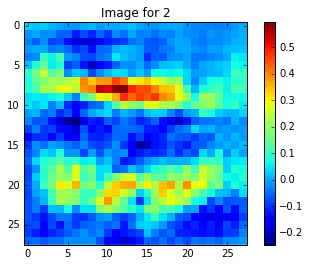

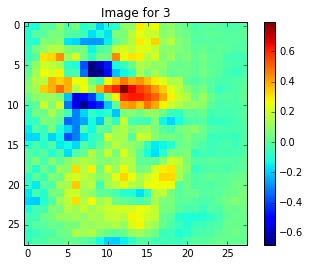

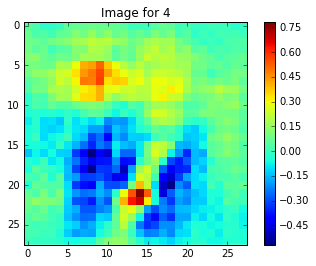

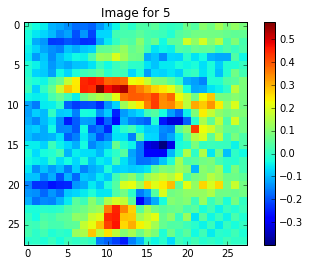

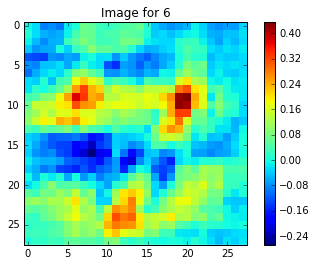

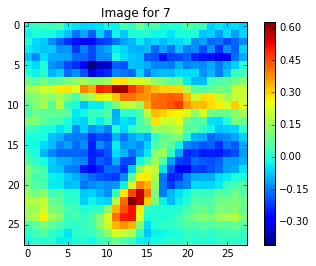

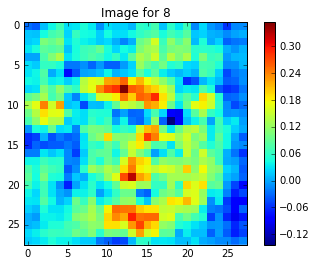

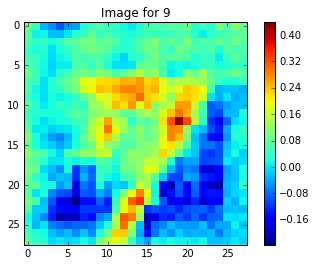

In [15]:
# y_res = sess.run(h_conv1, {x:test_x.reshape(-1, 784)})

for i in range(10):
    deriv = tf.gradients(y_conv[0][i], x)
    # y_res[0][1

    dydx = sess.run(deriv, {x:test_x.reshape(-1, 784)})

    dydx = np.array(dydx)
    
    fig, ax = plt.subplots()

    im = ax.imshow(dydx.reshape((28, 28)), cmap='jet', interpolation='none')

#     print('Image for {}'.format(i))
    plt.title('Image for {}'.format(i))
    fig.colorbar(im, ax=ax)

#     plt.savefig('./Output/LeNet/Output_Layer/filter_{}.jpg'.format(i))